## bcc_mock-number density

In [1]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### calling BCC-buzzard 

Remove objects having crazy colors or undetected in all bands.

In [2]:
def priorCut_buz(merged_buz):
    basicmask = (
                 ( merged_buz['MAG_G'] > 15.0 ) & ( merged_buz['MAG_G'] < 25.0 ) &
                 ( merged_buz['MAG_R'] > 15.0 ) & ( merged_buz['MAG_R'] < 25.0 ) &
                 ( merged_buz['MAG_I'] > 15.0 ) & ( merged_buz['MAG_I'] < 22.0 ) &
                 ( merged_buz['MAG_Z'] > 15.0 ) & ( merged_buz['MAG_Z'] < 25.0 ) &
                 ( merged_buz['MAG_G'] - merged_buz['MAG_R'] < 2.5 ) &
                 ( merged_buz['MAG_G'] - merged_buz['MAG_R'] > -0.5 ) &
                 #( merged_buz['MAG_G'] - merged_buz['MAG_R'] > 0.0 ) &
                 ( merged_buz['MAG_R'] - merged_buz['MAG_I'] < 2.0 ) &
                 ( merged_buz['MAG_R'] - merged_buz['MAG_I'] > -0.5 )
                 #( merged_buz['MAG_R'] - merged_buz['MAG_I'] > 0.0 )
                 )
    return merged_buz[basicmask]

In [3]:
# code for unfolding sdss-buz
def unfold_buz(buz_sdss):
    #buz_sdss = fitsio.read(path+name)
    dtype = [('OMAG_'+f, float) for f in ['G', 'R', 'I', 'Z']] \
    +  [('OMAGERR_'+f, float) for f in ['G', 'R', 'I', 'Z']] \
    + [('AMAG_'+f, float) for f in ['G', 'R', 'I', 'Z']] \
    + [('LMAG_'+f, float) for f in ['G', 'R', 'I', 'Z']] \
    + [('TMAG_'+f, float) for f in ['G', 'R', 'I', 'Z']]
    
    buz_sdss_df = np.zeros((buz_sdss.size,), dtype=dtype)
    
    for i, f in enumerate(['G', 'R', 'I','Z']):
        buz_sdss_df['OMAG_'+f] = buz_sdss['OMAG'][:,i+1]
        buz_sdss_df['OMAGERR_'+f] = buz_sdss['OMAGERR'][:,i+1]
        buz_sdss_df['AMAG_'+f] = buz_sdss['AMAG'][:,i+1]
        buz_sdss_df['LMAG_'+f] = buz_sdss['LMAG'][:,i+1]
        buz_sdss_df['TMAG_'+f] = buz_sdss['TMAG'][:,i+1]
    
    #fitsio.write(path+'Buzzard_v1.1_stripe82_mag.unfold.60.fit', buz_sdss_df)
    return buz_sdss_df

In [4]:
# calling map 
GoldMask = callingEliGoldMask()

Calling buzzard des and sdss catalogs.

In [5]:
# calling all catalogues having a specific keyword in their name
path = '/n/des/lee.5922/data/buzzard/'
HPix = [24,84,112,144]
tables = [path+'Buzzard_v1.1_Y1A1.'+str(c)+'.fit' for c in HPix]
tables2 = [path+'Buzzard_v1.1_stripe82_mag.unfold.'+str(c)+'.fit' for c in HPix]
buz = np.hstack([esutil.io.read(t) for t in tables])
buz_sdss = np.hstack([esutil.io.read(t) for t in tables2])

In [6]:
#rows = np.random.choice(buz.size, size = int(buz.size/5.))
merged_buz = mergeCatalogsUsingPandas(des=buz, gold=buz_sdss, how = 'outer', key=None, suffixes = ['',''],\
                                      left_index=True, right_index=True)
merged_buz = priorCut_buz(merged_buz)

In [9]:
merged_buz = Cuts.keepGoodRegion(merged_buz)

In [10]:
A = np.sum([getHPArea(pix = c, nside2 = 8) for c in HPix])
print merged_buz.size /A, merged_buz.size, A

12077.4349775 857414 70.993054535


Make Fake CMASS sample

In [11]:
dperp = ( merged_buz['OMAG_R'] - merged_buz['OMAG_I'] ) - ( merged_buz['OMAG_G'] - merged_buz['OMAG_R'])/8.0
fakemask =(
            ( merged_buz['OMAG_I'] < 19.86 + 1.6 * (dperp - 0.8)) &
            #( merged_buz['OMAG_I'] > 17.5 ) & ( merged_buz['OMAG_I'] < 20.0 ) &
            ( merged_buz['OMAG_I'] > 17.5 ) & ( merged_buz['OMAG_I'] < 20.0 ) &
            ( merged_buz['OMAG_R'] - merged_buz['OMAG_I'] < 2.0 ) &
            #( merged_buz['OMAG_R'] - merged_buz['OMAG_I'] > 0.0 ) &
            ( dperp > 0.55 )
            )
fakecmass = merged_buz[fakemask]

Fit data with XD

In [ ]:
# Divide sample into train and test
(trainInd, testInd), _ = split_samples(merged_buz, merged_buz, [0.2,0.8], random_state=0)
des_train = merged_buz[trainInd]
des_test = merged_buz[testInd]

m1, m2 = esutil.numpy_util.match(fakecmass['ID'], des_train['ID'])
cmass_mask = np.zeros(des_train.size, dtype=bool)
cmass_mask[m2] = 1
fakecmass_train, nocmass_train = des_train[cmass_mask], des_train[~cmass_mask]

In [ ]:
des_train.size, fakecmass.size, fakecmass_train.size

In [ ]:
#rm pickle/buz_XD_cmass_tor_noricut6.pkl

In [16]:
# Fitting
pickleFileName = 'pickle/buz_XD_cmass_tor8.pkl'
clf_cmass = XD_fitting2( fakecmass_train, pickleFileName = pickleFileName, \
                  #init_params= 'pickle/buz_XD_cmass_tor_noricut6.pkl',\
                        suffix = '_cmass', n_cl = 10 )

@pickle_results: using precomputed results from 'pickle/buz_XD_cmass_tor7.pkl'


In [17]:
pickleFileName = 'pickle/buz_XD_no_tor7.pkl'
rows = np.random.choice(nocmass_train.size, size=int(nocmass_train.size/10.))                    
clf_no = XD_fitting2( nocmass_train, pickleFileName = pickleFileName, \
                  init_params= 'pickle/buz_XD_no_tor7.pkl', \
                     suffix = '_no', n_cl = 25 )

@pickle_results: using precomputed results from 'pickle/buz_XD_no_tor7.pkl'


Assign Fake cmass memb prob to test sample

In [38]:
cmass_fraction = fakecmass_train.size * 1./des_train.size
print 'cmass_fraction', cmass_fraction
from xd import assignCMASSProb
des_test = assignCMASSProb( des_test, clf_cmass, clf_no, cmass_fraction = 0.012 )
#buz_test = assignCMASSProb( buz_test, clf_cmass, clf_no, cmass_fraction = cmass_fraction )

cmass_fraction 0.00935958292999
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


###### Check model probability

save fig: com_pur_results/test_probability_calibration.png


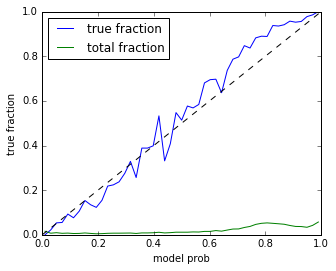

In [39]:
probability_calibration( des = des_test, cmass_des = fakecmass, matchID= 'ID', prefix = 'test' )

###### Make DMASS by resampling

In [40]:
dmass_buz, _ = resampleWithPth( des_test, pstart = 0, pmax = 1.0 )

#### Comparison of error-convolved model and observed data

In [25]:
cmass_model = clf_cmass.sample(fakecmass_train.size)
no_model = clf_no.sample(nocmass_train.size)

X_train, Xcov_train = mixing_color_buz(des_train)
X_test,_ = mixing_color_buz(des_test)

noisy_cmass_model = add_errors_multiprocessing(cmass_model, X_train[cmass_mask], Xcov_train[cmass_mask])
nosiy_no_model = add_errors_multiprocessing(no_model, X_train[~cmass_mask], Xcov_train[~cmass_mask])

add noise to sample 100 %
add noise to sample 100 %


writing output plot to: figure/buz_model_cmass_diagnostic_histograms_1d.png
writing output plot to: figure/buz_model_no_diagnostic_histograms_1d.png


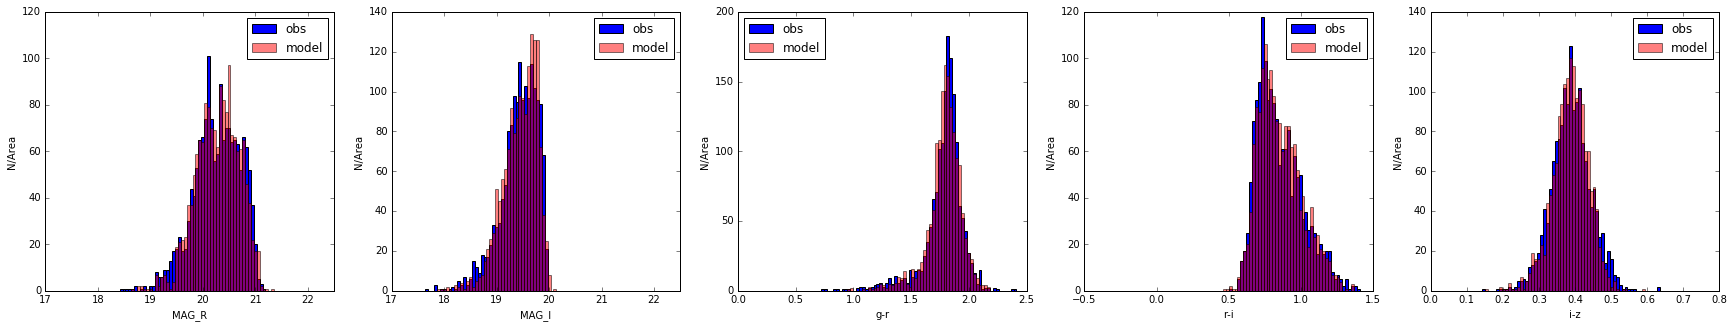

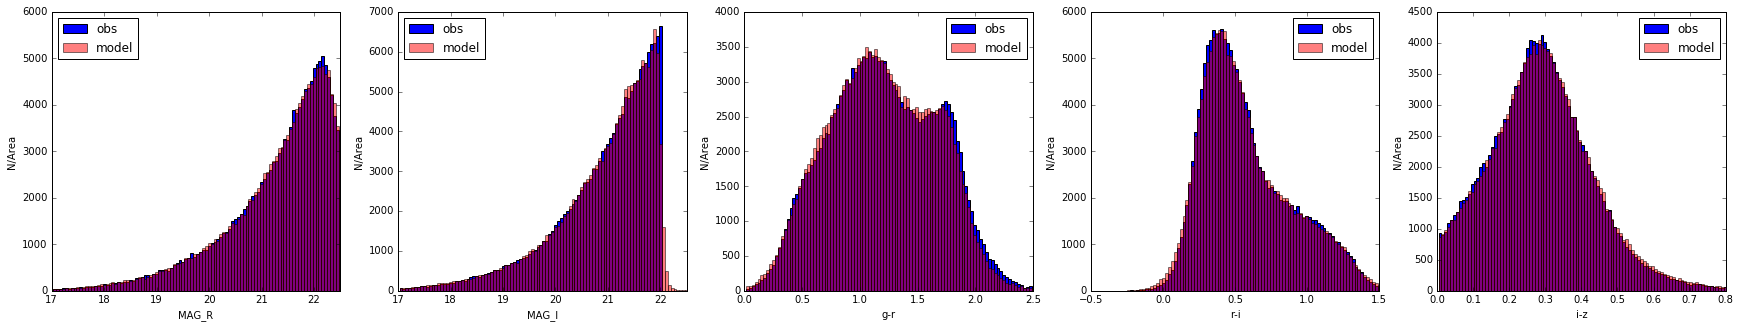

In [26]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [.0,2.5], [-.5,1.5], [0.0,.8]]
doVisualization_1d_NperA( noisy_cmass_model, X_train[cmass_mask], area=[1,1], labels = labels, ranges = ranges,\
                         name =['model','obs' ], nbins=100, prefix='buz_model_cmass_')
doVisualization_1d_NperA( nosiy_no_model, X_train[~cmass_mask], area=[1,1], labels = labels, ranges = ranges,\
                         name =['model','obs' ], nbins=100, prefix='buz_model_no_')

#### Comparison with train and test observational data

writing output plot to: figure/buz_all_diagnostic_histograms_1d.png


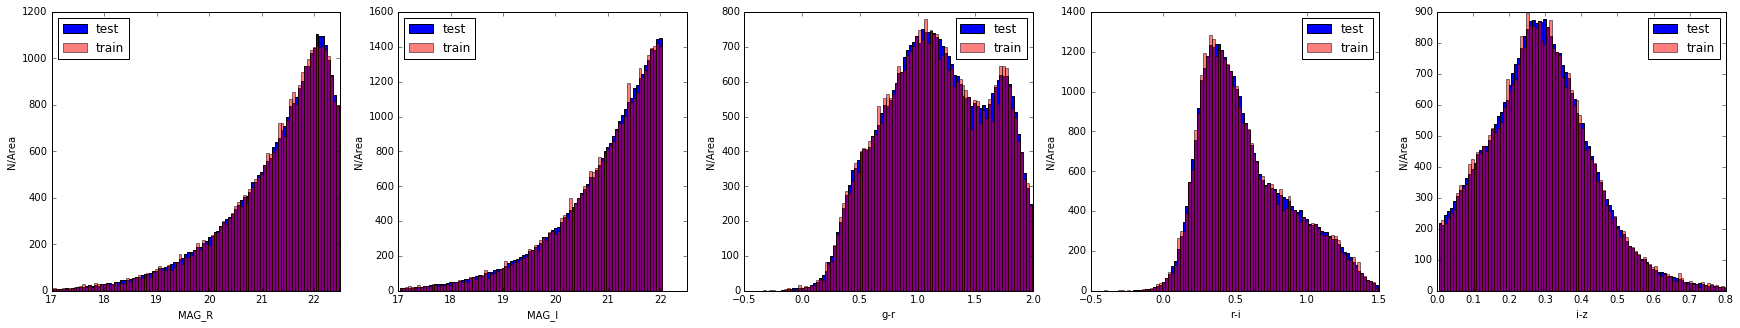

In [35]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-0.5,2], [-.5,1.5], [0.0,.8]]
#X_buz,_ = mixing_color_buz(buz_test)
rows = np.random.choice(nocmass_train.size, size=int(nocmass_train.size/2.)) 
doVisualization_1d_NperA( X_train[rows,:], X_test, area=[1,8], labels = labels, ranges = ranges,\
                         name =['train','test' ], nbins=100, prefix='buz_all_')

writing output plot to: figure/buz_dmass_diagnostic_histograms_1d.png


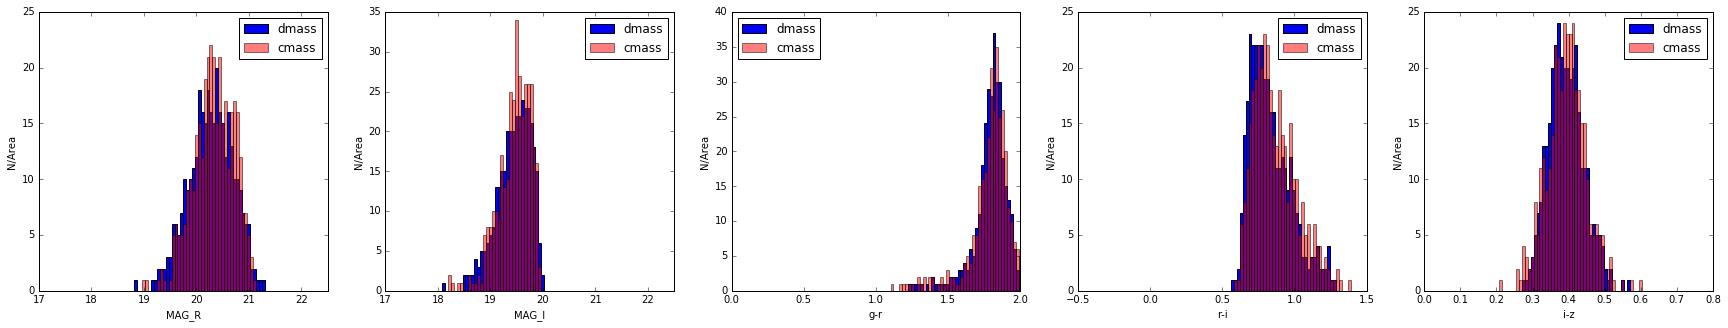

In [39]:
# Plotting dmass
X_cmass,_ = mixing_color_buz(fakecmass_train)
X_dmass,_ = mixing_color_buz(dmass_buz)
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [0,2], [-.5,1.5], [0.0,.8]]
doVisualization_1d_NperA( X_cmass, X_dmass, area=[2,8], labels = labels, ranges = ranges,\
                         name =['cmass','dmass' ], nbins=100, prefix='buz_dmass_')

#### bias and number density of DMASS

In [27]:
def getavgbias( cat, pstart=0.0 ):
    from systematics_module.contCorrection import logL_from_mag,logL_to_galaxyBias
    mag = cat['MAG_I']
    z = cat['PHOTOZ_GAUSSIAN']
    logL = logL_from_mag( mag = mag, z = z )
    avg_b = logL_to_galaxyBias(logL = logL)
    print 'avg bias=',avg_b, ' sample size=', mag.size
    return avg_b

In [41]:
avg_b_cmass = getavgbias( fakecmass_train )
avg_b_dmass = getavgbias( dmass_buz )
print 'num_density', fakecmass_train.size * 4 *1./dmass_buz.size * 100 , '%' 
print 'bias ratio', avg_b_cmass /avg_b_dmass * 100, '%'

avg bias= 1.35694794302  sample size= 1605
avg bias= 1.29993529768  sample size= 6026
num_density 106.538333886 %
bias ratio 104.385806389 %


----

### Testing Same region with DES SPT

Find heapix index for given range

In [8]:
# testing for same area of des_gold 
def getHealInd_buz(ra, ra2, dec, dec2):
    #ra = np.linspace(0, 50, 2000)
    #dec = np.random.choice(np.linspace(-52, -50, 10), size = 2000)
    ra = np.linspace(ra, ra2, 2000)
    dec = np.random.choice(np.linspace(dec, dec2, 10), size = 2000)
    #Buzzard rotational matrix
    rmat = np.array([ 0.382192, 0.054546, 0.922472,\
                     -0.924079, 0.025571, 0.381346,\
                     -0.002787, -0.998184, 0.060177 ]).reshape(3,3)
    vec  = hp.ang2vec(-(dec - 90.) * np.pi / 180., ra * np.pi / 180.)
    rvec = np.dot(np.linalg.inv(rmat), vec.T)
    pix  = set(hp.vec2pix(8, *rvec, nest=False))
    print 'Healpix ind ', np.sort(list(pix))
    return np.sort(list(pix))

In [12]:
ra, ra2, dec, dec2 = [0, 50, -52, -50]
#ra, ra2, dec, dec2 = [320, 360, -1, 1]
pix = getHealInd_buz(ra, ra2, dec, dec2)

Healpix ind  [119 120 151 152 153 182 183 184 185]


In [14]:
# testing for other regions (same with des spt)
path = '/n/des/lee.5922/data/buzzard/'
buz_test_list = []
for p in pix:
    cat = priorCut_buz(fitsio.read(path+'Buzzard_v1.1_Y1A1.'+str(p)+'.fit'))
    cat = Cuts.keepGoodRegion(cat)
    print 'Buzzard_v1.1_Y1A1.'+str(p)+'.fit'
    cat = assignCMASSProb( cat, clf_cmass, clf_no, cmass_fraction = 0.012 ) 
    buz_test_list.append(cat)
    cat = None

Buzzard_v1.1_Y1A1.119.fit
Buzzard_v1.1_Y1A1.120.fit
Buzzard_v1.1_Y1A1.151.fit
Buzzard_v1.1_Y1A1.152.fit
Buzzard_v1.1_Y1A1.153.fit
Buzzard_v1.1_Y1A1.182.fit
Buzzard_v1.1_Y1A1.183.fit
Buzzard_v1.1_Y1A1.184.fit
Buzzard_v1.1_Y1A1.185.fit


In [11]:
#train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
train_area = np.sum([getHPArea(pix = p) for p in HPix])/5
nd =  des_train.size/train_area

nd_ratio = []
for i, d in enumerate(buz_test_list):
    test_area = getHPArea(pix = pix[i]) #* 1/5    
    nd_ratio.append(d.size /test_area /nd)

NameError: name 'HPix' is not defined

In [36]:
# histograms
dmass_buz_list = []
for i, p in enumerate(pix):
    dmass_buz , _ = resampleWithPth( buz_test_list[i], pstart = 0, pmax = 1.0 )
    dmass_buz_list.append(dmass_buz)

writing output plot to: figure/buz_dmass_pix119_diagnostic_histograms_1d.png
writing output plot to: figure/buz_all_pix119_diagnostic_histograms_1d.png
writing output plot to: figure/buz_dmass_pix120_diagnostic_histograms_1d.png
writing output plot to: figure/buz_all_pix120_diagnostic_histograms_1d.png
writing output plot to: figure/buz_dmass_pix151_diagnostic_histograms_1d.png
writing output plot to: figure/buz_all_pix151_diagnostic_histograms_1d.png
writing output plot to: figure/buz_dmass_pix152_diagnostic_histograms_1d.png
writing output plot to: figure/buz_all_pix152_diagnostic_histograms_1d.png
writing output plot to: figure/buz_dmass_pix153_diagnostic_histograms_1d.png
writing output plot to: figure/buz_all_pix153_diagnostic_histograms_1d.png
writing output plot to: figure/buz_dmass_pix182_diagnostic_histograms_1d.png
writing output plot to: figure/buz_all_pix182_diagnostic_histograms_1d.png
writing output plot to: figure/buz_dmass_pix183_diagnostic_histograms_1d.png
writing out

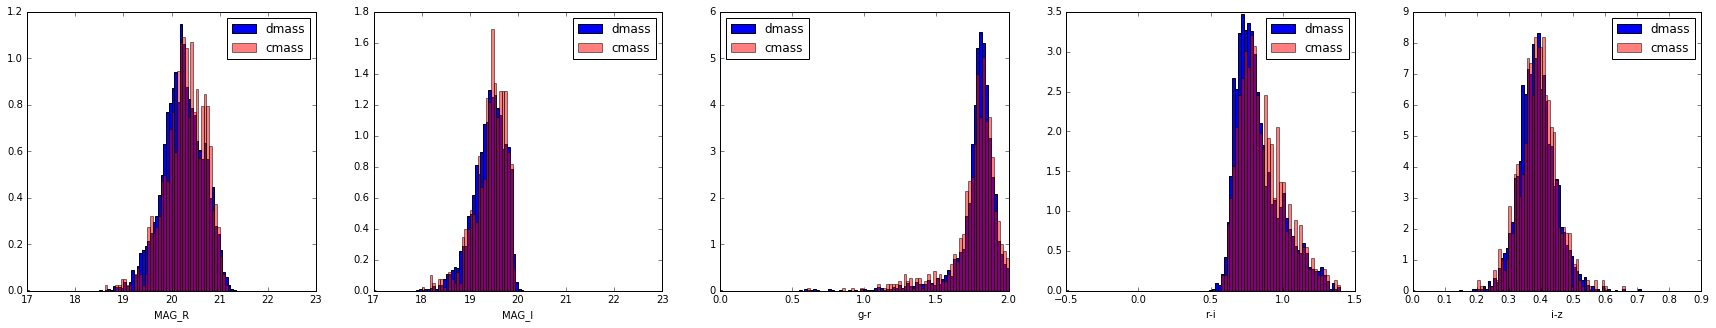

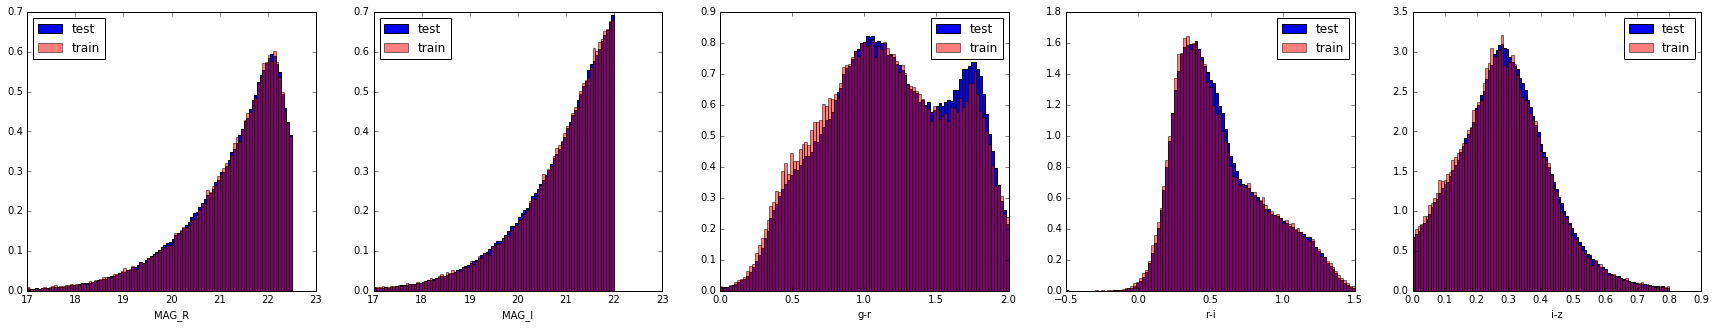

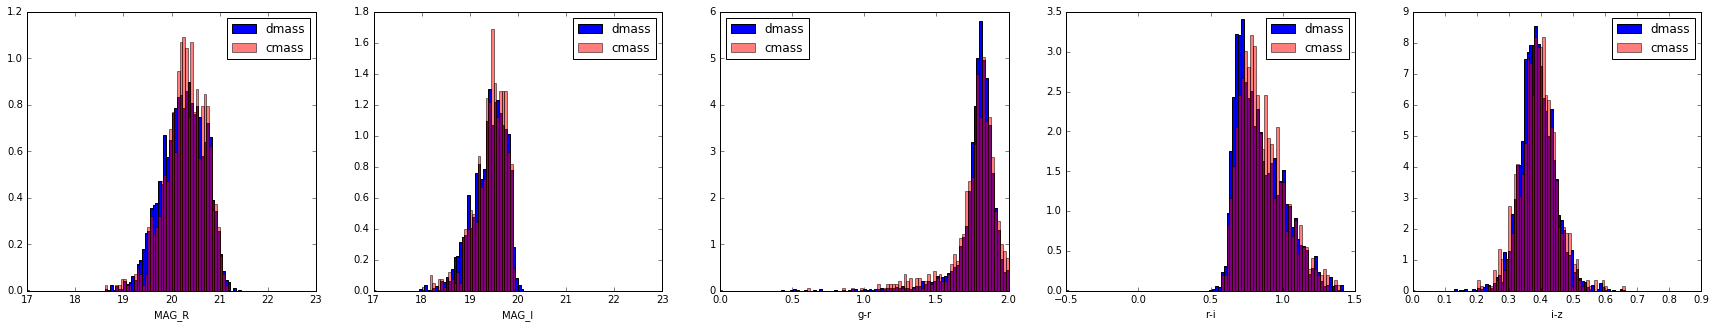

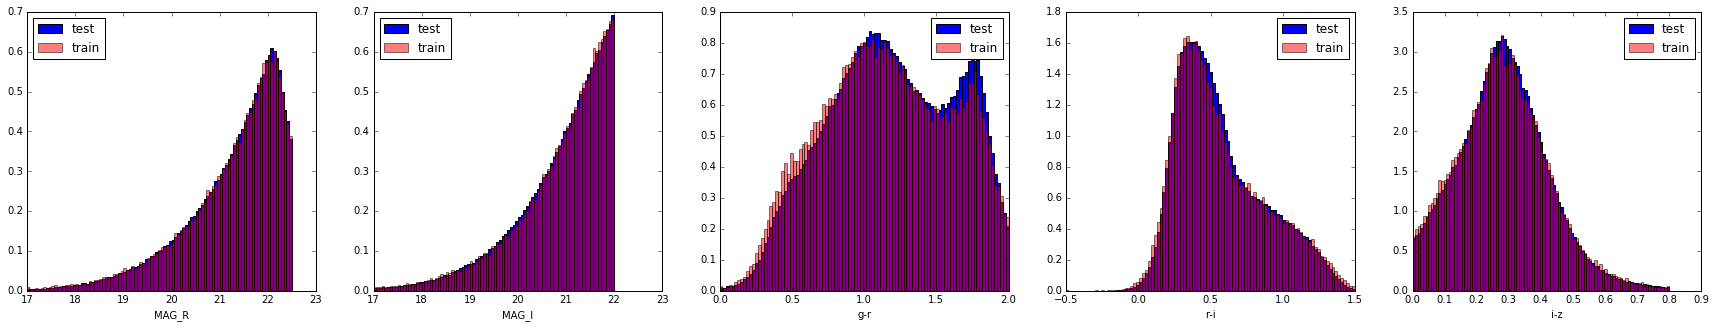

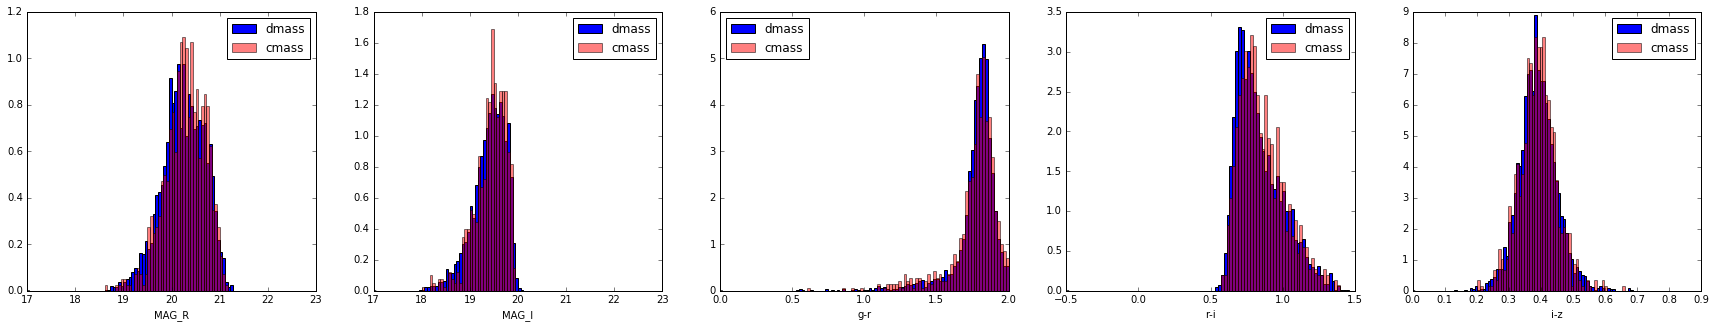

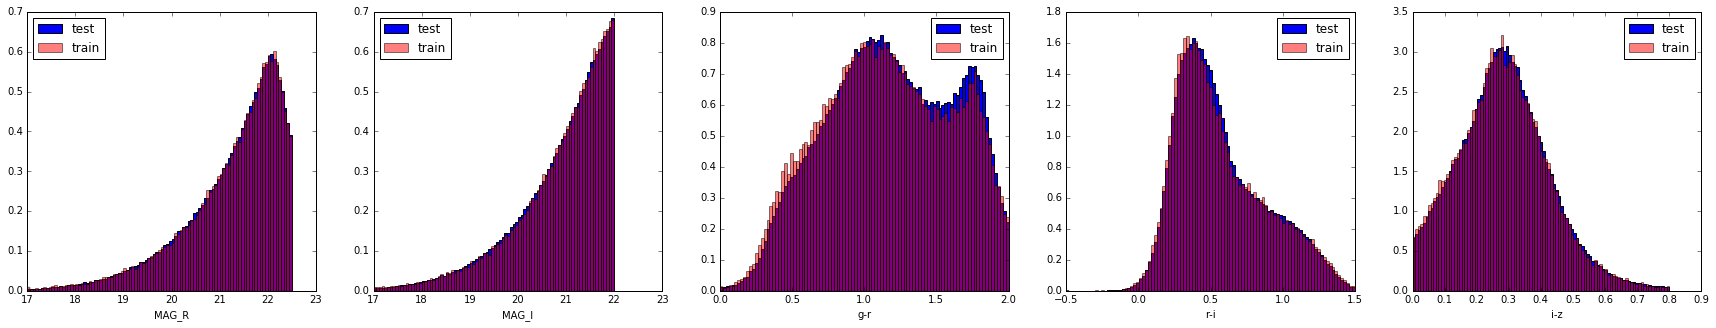

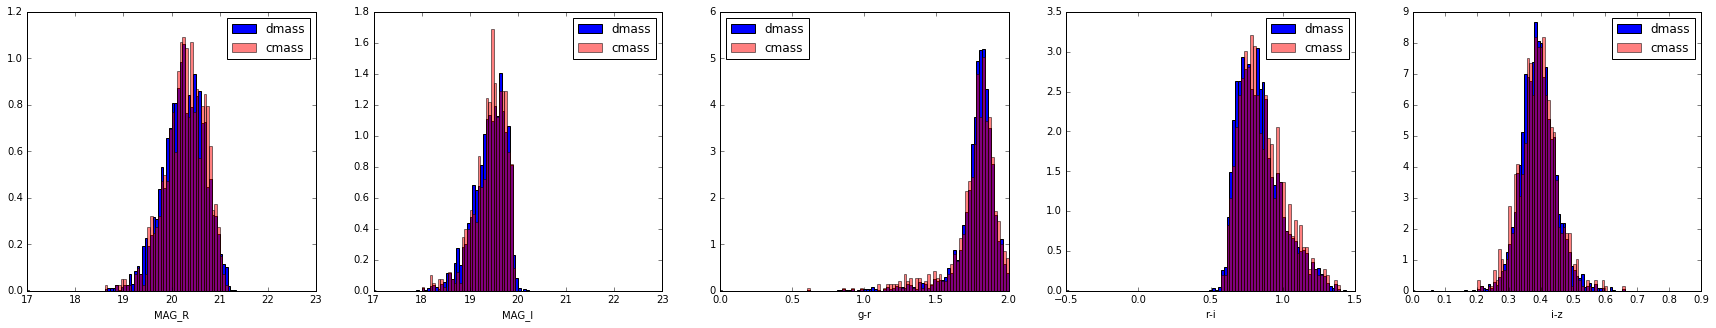

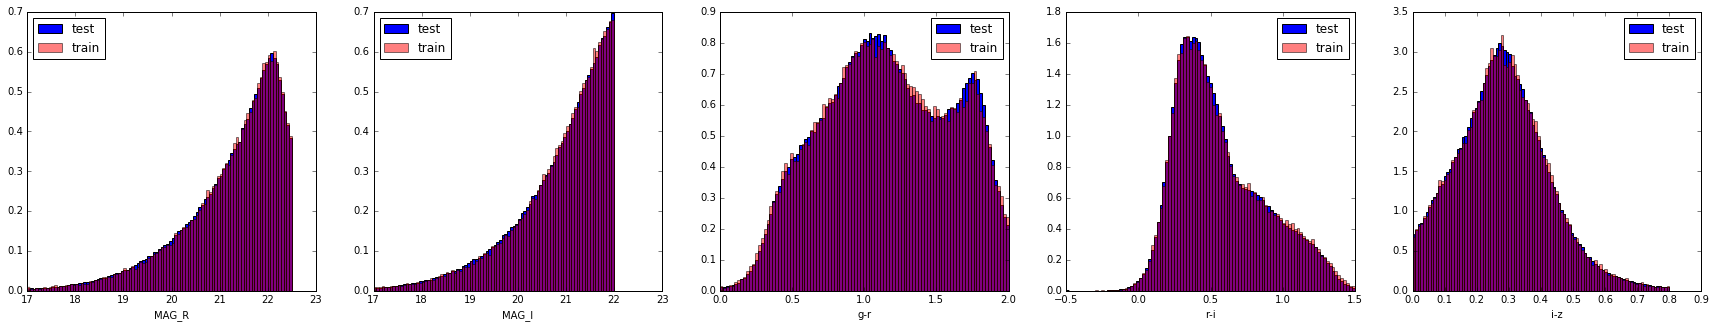

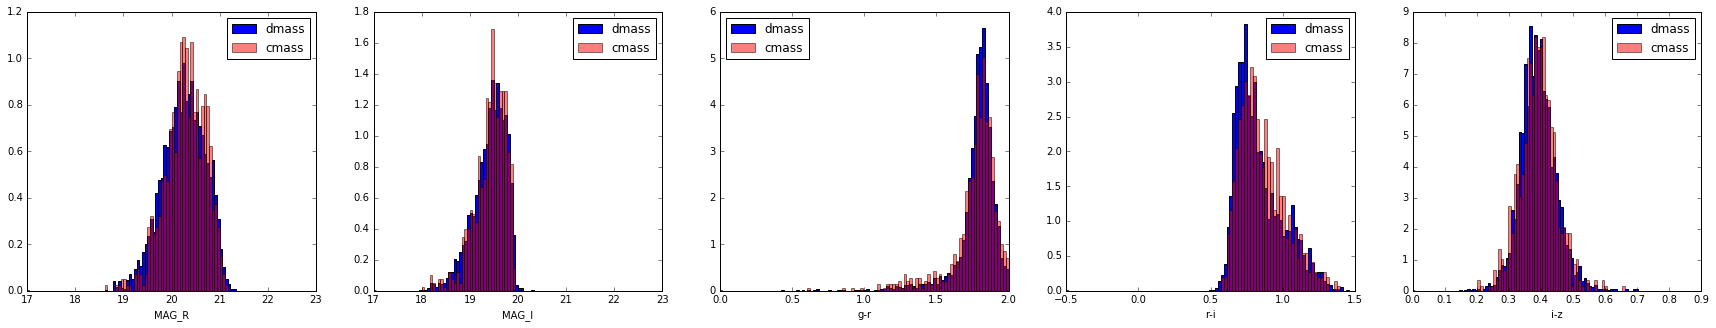

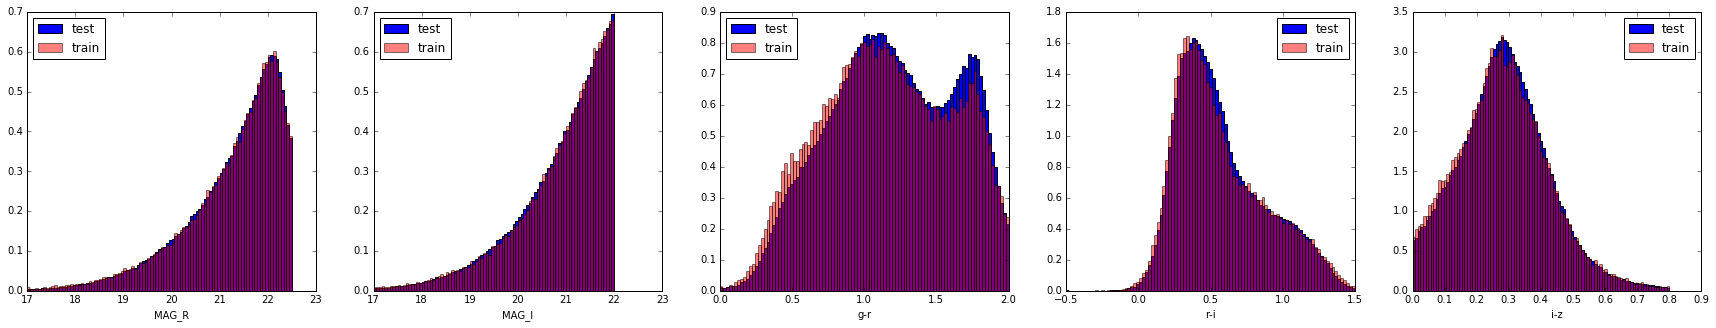

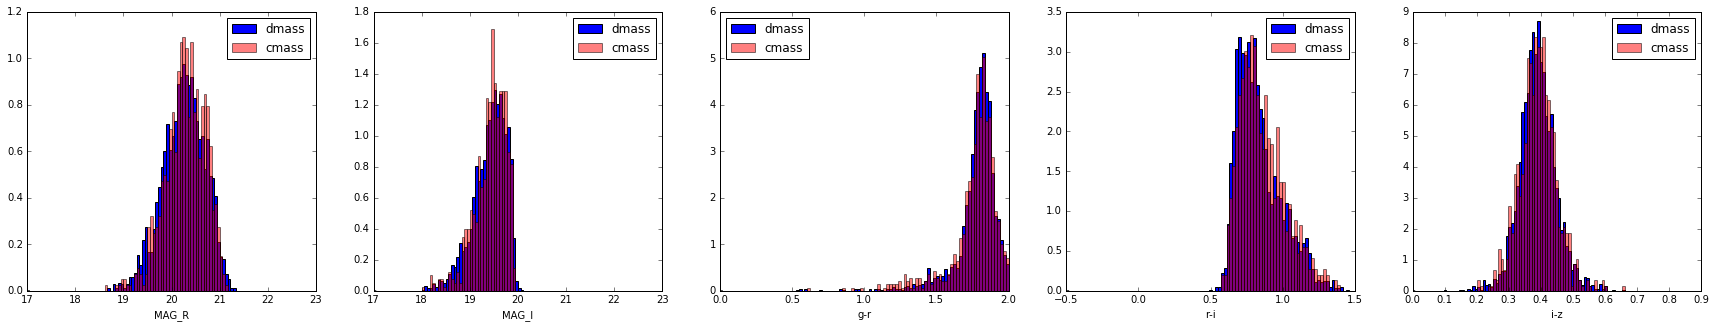

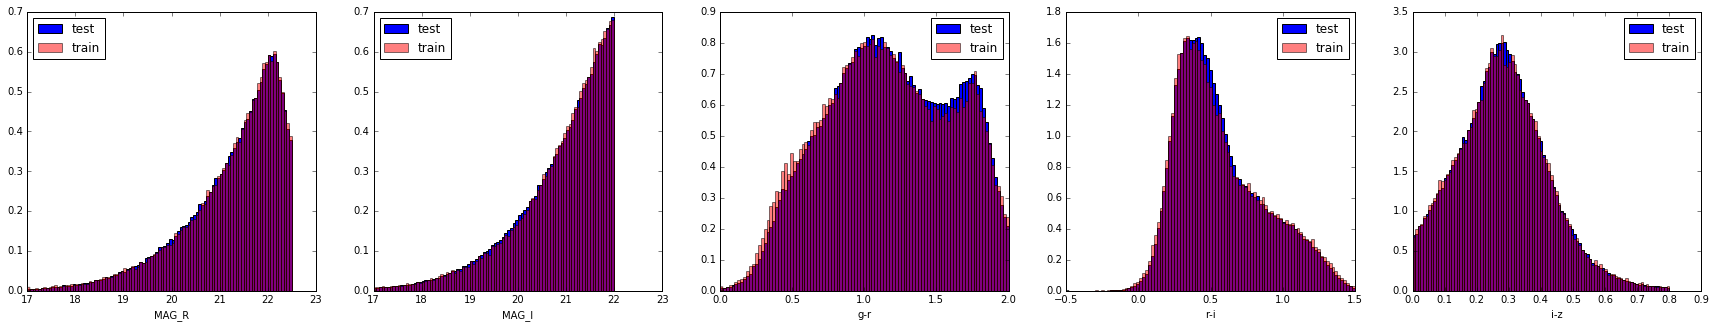

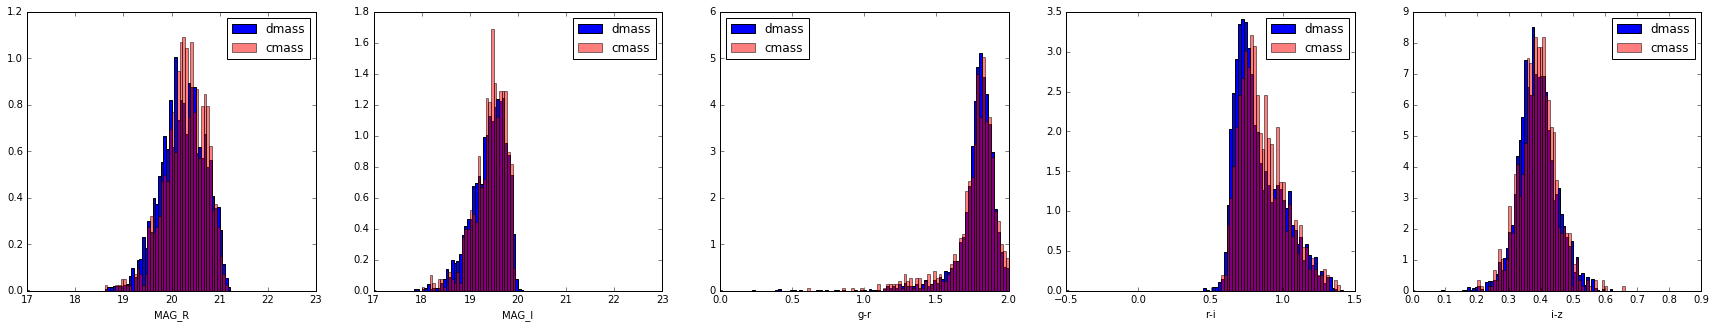

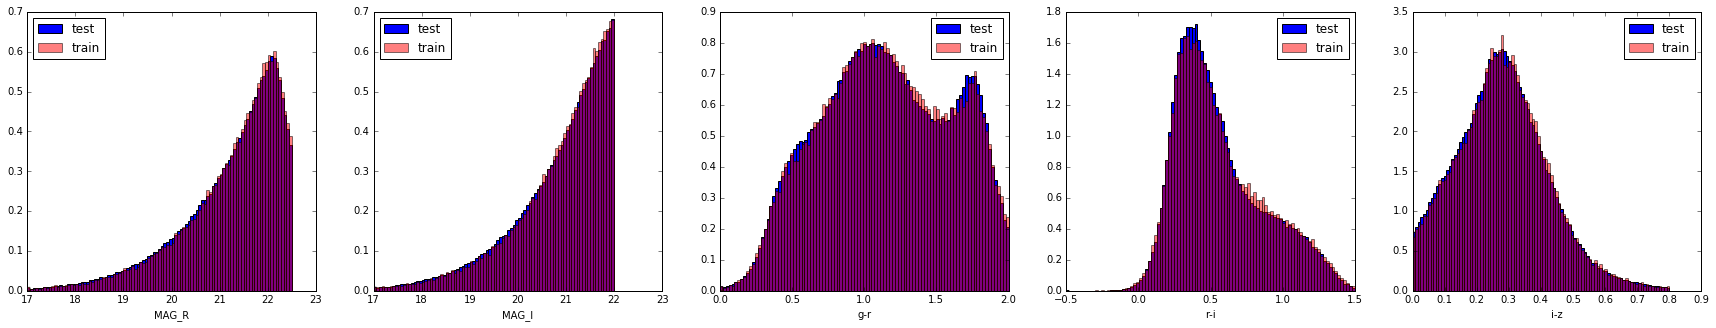

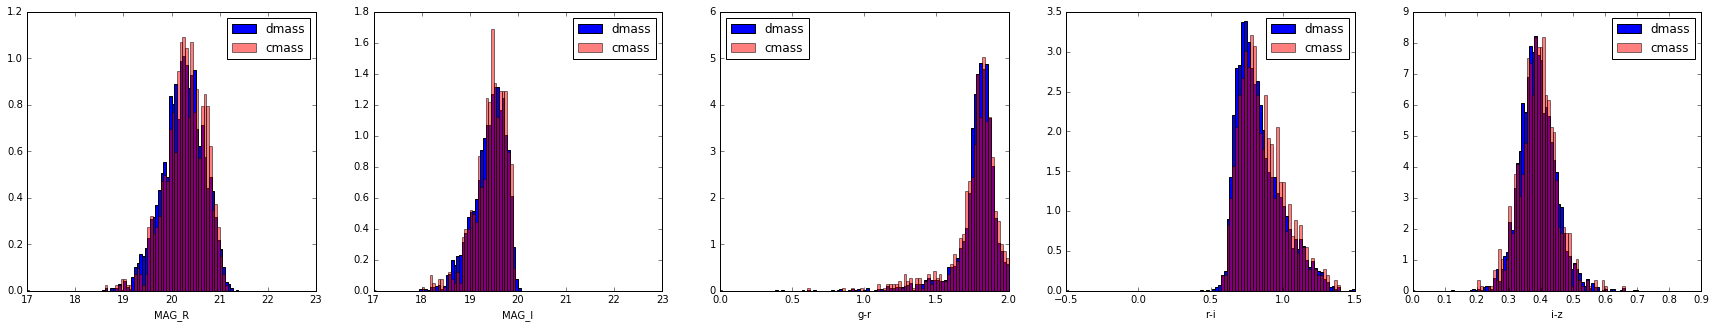

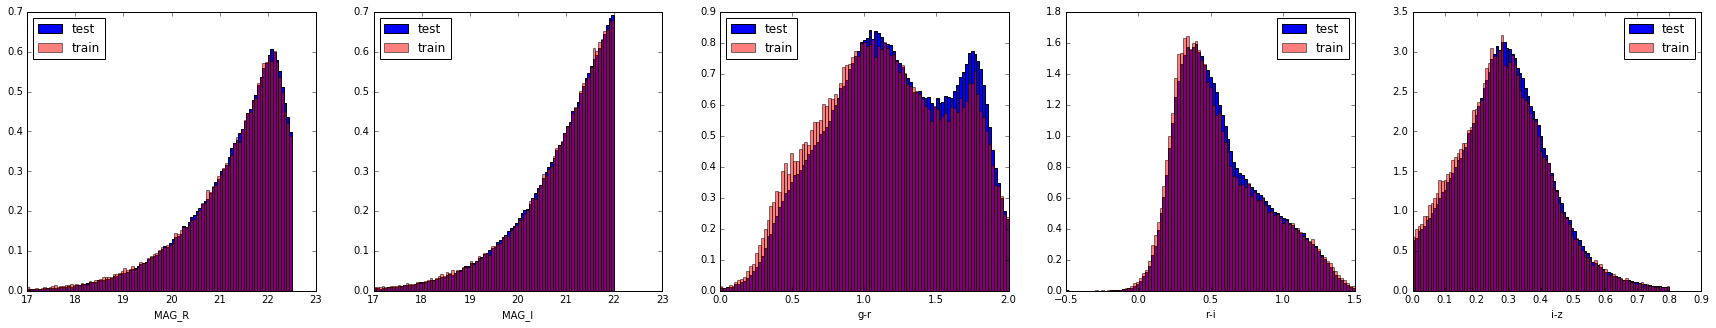

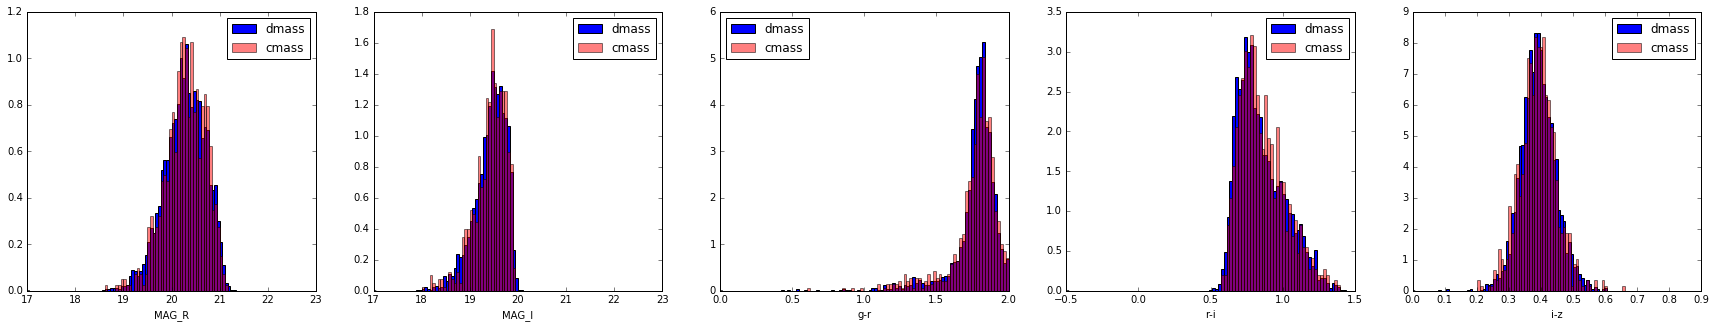

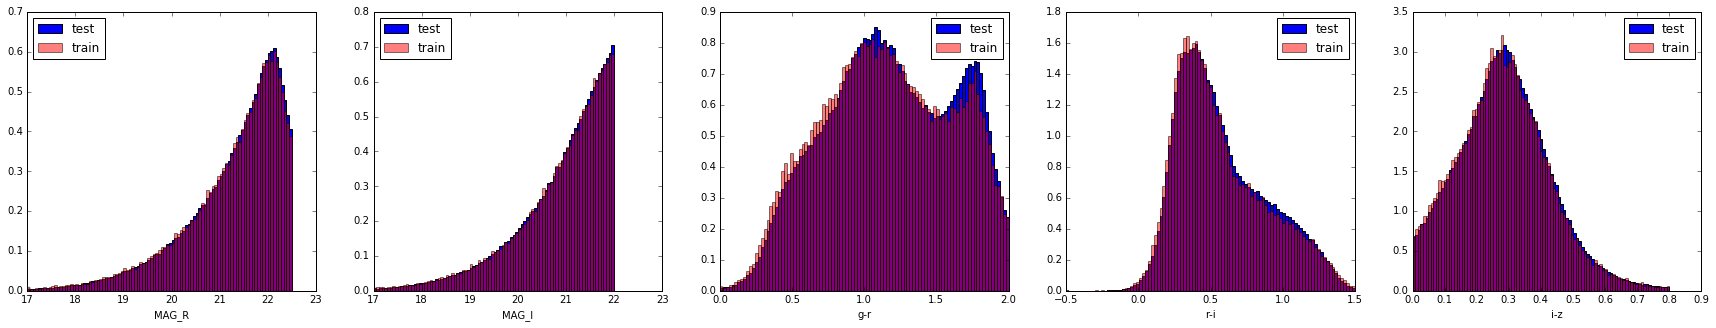

In [266]:
#train_area = (getHPArea(pix = 40) + getHPArea(pix = 60))/5
#for i in range(len(dmass_buz_list)):
for i, p in enumerate(pix):
    X_buz_dmass, _ = mixing_color_buz(dmass_buz_list[i])
    X_cmass, _ = mixing_color_buz(fakecmass_train)
    X_train,_ = mixing_color_buz(des_train)
    X_test,_ = mixing_color_buz(buz_test_list[i])
    labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
    ranges =  [[17,22.5], [17,22.5], [0,2], [-.5,1.5], [0.0,.8]]
    #test_area = getHPArea(cat=buz_test[i], nside=512)
    test_area = getHPArea(pix = pix[i])
    #doVisualization_1d_NperA( X_cmass, X_buz_dmass, area=[train_area ,test_area], labels = labels, ranges = ranges,\
    #                         name =['cmass','dmass'], nbins=100, prefix='buz_dmass_pix'+str(p)+'_')
    #doVisualization_1d_NperA( X_train, X_test, area=[train_area,test_area], labels = labels, ranges = ranges,\
    #                         name =['train','test' ], nbins=100, prefix='buz_all_pix'+str(p)+'_')
    doVisualization_1d( X_cmass, X_buz_dmass, labels = labels, ranges = ranges,\
                             name =['cmass','dmass'], nbins=100, prefix='buz_dmass_pix'+str(p)+'_')
    doVisualization_1d( X_train, X_test, labels = labels, ranges = ranges,\
                             name =['train','test' ], nbins=100, prefix='buz_all_pix'+str(p)+'_')

In [37]:
# bias

#train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
train_area = np.sum([getHPArea(pix = p) for p in HPix])
num_density = fakecmass.size/train_area
print 'num density', num_density
print 'area', test_area
avg_b_cmass = getavgbias( fakecmass )
print '-----------------------------'

nd_ratio_cmass = []
bias_ratio = []
for i,p in enumerate(pix):
    test_area = getHPArea(pix = p)
    num_d = dmass_buz_list[i].size/test_area
    print p, 'num density', num_d, num_d/num_density * 100, '%'
    nd_ratio_cmass.append(num_d/num_density)
    print 'area', test_area
    avg_b_dmass = getavgbias( dmass_buz_list[i] )
    print '-----------------------------'
    bias_ratio.append(avg_b_dmass/avg_b_cmass)

num density 113.236429291
area 45.8478497094
avg bias= 1.34519624561  sample size= 8039
-----------------------------
119 num density 106.897190169 94.4017670268 %
area 43.6494167212
avg bias= 1.28995254522  sample size= 4666
-----------------------------
120 num density 98.0581000109 86.5958955302 %
area 46.7477954344
avg bias= 1.31313251446  sample size= 4584
-----------------------------
151 num density 105.188854164 92.8931217826 %
area 39.2722216897
avg bias= 1.30114084499  sample size= 4131
-----------------------------
152 num density 94.2230033551 83.2090908775 %
area 45.4878304382
avg bias= 1.30400902974  sample size= 4286
-----------------------------
153 num density 96.6875897931 85.3855869516 %
area 48.7859921847
avg bias= 1.29170911236  sample size= 4717
-----------------------------
182 num density 103.556226975 91.4513356021 %
area 28.9697692514
avg bias= 1.28679711913  sample size= 3000
-----------------------------
183 num density 94.2505983625 83.2334602501 %
area 35.

In [15]:
def grmask(cat):
    gr_mask = (((cat['MAG_G'] - cat['MAG_R']) > 1.3 ) &
               ((cat['MAG_G'] - cat['MAG_R']) < 1.8 ))
    #cat = cat[gr_mask]
    return gr_mask

In [16]:
gr_train = np.sum(grmask(merged_buz))
test_area = getHPArea(pix = 40) + getHPArea(pix = 60)
n_gr_train = gr_train/test_area

nd_gr = []
for i, d in enumerate(buz_test_list):
    a = getHPArea(pix = pix[i])
    mask = grmask(d)
    nd = np.sum(mask)/a * 1./n_gr_train
    nd_gr.append(nd)

NameError: name 'merged_buz' is not defined

In [313]:
avg_buz_test = np.hstack(buz_test_list)
avg_dmass_buz = np.hstack(dmass_buz_list)
#dmass_buz , _ = resampleWithPth( avg_buz_test, pstart = 0, pmax = 1.0 )
test_area = np.sum([getHPArea(pix = p) for p in pix])
num_dmass = avg_dmass_buz.size/test_area /num_density
avg_b_dmass = getavgbias( avg_dmass_buz ) /avg_b_cmass
nd_test =  avg_buz_test.size/test_area /nd
print num_dmass, avg_b_dmass

avg bias= 1.29506653903  sample size= 40967
0.97429553093 0.969667480344


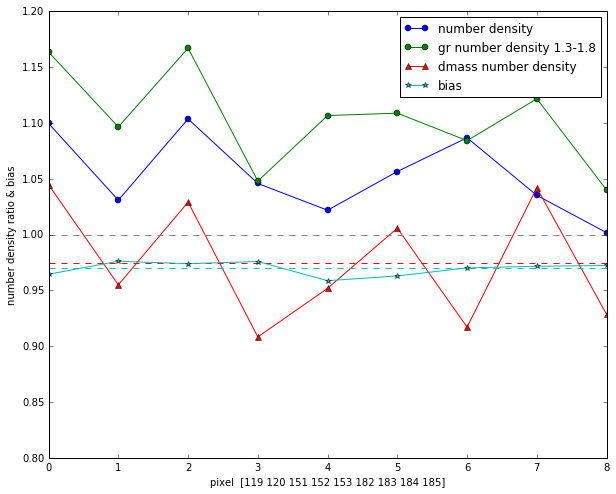

In [308]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(range(len(pix)),nd_ratio, '-o', label = 'number density' )
ax.plot(range(len(pix)),nd_gr, '-o', label = 'gr number density 1.3-1.8' )
ax.plot(range(len(pix)), nd_ratio_cmass, '-^', label='dmass number density')
ax.axhline(y = num_dmass, linestyle='--', color=ax.lines[-1].get_color())
ax.plot(range(len(pix)), bias_ratio, '-*', label = 'bias')
ax.axhline(y = avg_b_dmass, linestyle='--', color=ax.lines[-1].get_color())
ax.axhline(y = 1.0, linestyle='--', color = 'grey')
ax.set_ylim(0.8, 1.20)
ax.set_xlabel('pixel  ' + str(pix))
ax.set_ylabel('number density ratio & bias')
ax.legend(loc='best')

figsave : figure/spatialtest_buz_test.png


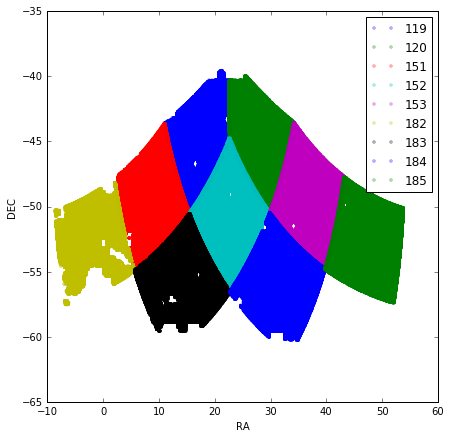

In [223]:
spatialcheck(buz_test_list, label=pix, suffix = 'buz_test')

#### Testing Region 3

In [267]:
pix3

array([ 24,  40,  60,  84, 112, 144, 176, 208])

In [309]:
# testing for other regions 
path = '/n/des/lee.5922/data/buzzard/'
buz_test_list2 = []
pix2 = [40, 60, 24, 84, 112, 144]# + [90, 91]
for p in pix2:
    cat = priorCut_buz(fitsio.read(path+'Buzzard_v1.1_Y1A1.'+str(p)+'.fit'))
    cat = Cuts.keepGoodRegion(cat)
    cat = assignCMASSProb( cat, clf_cmass, clf_no, cmass_fraction = cmass_fraction ) 
    buz_test_list2.append(cat)
    cat = None

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


In [310]:
train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
nd =  merged_buz.size/train_area

nd_ratio2 = []
for i, d in enumerate(buz_test_list2):
    test_area = getHPArea(pix = pix2[i]) #* 1/5    
    nd_ratio2.append(d.size /test_area /nd)

In [311]:
# histograms
dmass_buz_list2 = []
for i, p in enumerate(pix2):
    dmass_buz , _ = resampleWithPth( buz_test_list2[i], pstart = 0, pmax = 1.0 )
    dmass_buz_list2.append(dmass_buz)

In [1]:
# histograms
train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
for i, p in enumerate(pix2):
    
    #dmass_buz , _ = resampleWithPth( buz_test_list2[i], pstart = 0, pmax = 1.0 )
    X_buz_dmass, _ = mixing_color_buz(dmass_buz_list2[i])
    X_cmass, _ = mixing_color_buz(fakecmass_train)
    X_train,_ = mixing_color_buz(merged_buz)
    X_test,_ = mixing_color_buz(buz_test_list2[i])
    labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
    ranges =  [[17,22.5], [17,22.5], [0,2], [-.5,1.5], [0.0,.8]]
    test_area = getHPArea(pix = p)
    doVisualization_1d_NperA( X_cmass, X_buz_dmass, area=[train_area,test_area], labels = labels, ranges = ranges,\
                             name =['cmass','dmass'], nbins=100, prefix='buz_dmass_pix'+p+'_')
    doVisualization_1d_NperA( X_train, X_test, area=[train_area,test_area], labels = labels, ranges = ranges,\
                             name =['train','test' ], nbins=100, prefix='buz_all_pix'+p+'_')

NameError: name 'getHPArea' is not defined

In [314]:
# bias

train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
num_density = fakecmass.size/train_area
print 'num density', num_density
print 'area', train_area
avg_b_cmass = getavgbias( fakecmass )
print '-----------------------------'

nd_ratio_cmass2 = []
bias_ratio2 = []
for i,p in enumerate(pix2):
    test_area = getHPArea(pix = p)
    num_d = dmass_buz_list2[i].size/test_area
    print p, 'num density', num_d, num_d/num_density * 100, '%'
    nd_ratio_cmass2.append(num_d/num_density)
    print 'area', test_area
    avg_b_dmass = getavgbias( dmass_buz_list2[i] )
    print '-----------------------------'
    bias_ratio2.append(avg_b_dmass/avg_b_cmass)

num density 110.923270508
area 33.3744216433
avg bias= 1.3355779845  sample size= 3702
-----------------------------
40 num density 91.246506437 82.260923266 %
area 16.1430838014
avg bias= 1.31503599738  sample size= 1473
-----------------------------
60 num density 112.933773213 101.812516613 %
area 17.2313378419
avg bias= 1.30088342181  sample size= 1946
-----------------------------
24 num density 100.026068857 90.1759102475 %
area 14.7261610581
avg bias= 1.30524054669  sample size= 1473
-----------------------------
84 num density 104.963424217 94.6270550225 %
area 16.8344355492
avg bias= 1.30001446285  sample size= 1767
-----------------------------
112 num density 100.251944896 90.3795429366 %
area 20.2489837191
avg bias= 1.27930509011  sample size= 2030
-----------------------------
144 num density 114.36927306 103.106654299 %
area 19.1834742086
avg bias= 1.31072370419  sample size= 2194
-----------------------------


In [315]:
gr_train = np.sum(grmask(merged_buz))
train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
n_gr_train = gr_train/train_area

nd_gr2 = []
for i, d in enumerate(buz_test_list2):
    a = getHPArea(pix = pix2[i])
    mask = grmask(d)
    nd = np.sum(mask)/a * 1./n_gr_train
    nd_gr2.append(nd)

In [321]:
avg_buz_test2 = np.hstack(buz_test_list2)
avg_dmass_buz2 = np.hstack(dmass_buz_list2)
#dmass_buz , _ = resampleWithPth( avg_buz_test, pstart = 0, pmax = 1.0 )
test_area = np.sum([getHPArea(pix = p) for p in pix2])
num_dmass = avg_dmass_buz2.size/test_area /num_density
avg_b_dmass = getavgbias( avg_dmass_buz2 ) /avg_b_cmass
nd_test =  avg_buz_test2.size/test_area /nd
print avg_b_dmass, nd_test

avg bias= 1.30120639383  sample size= 10883
0.974264632191 10080.3887767


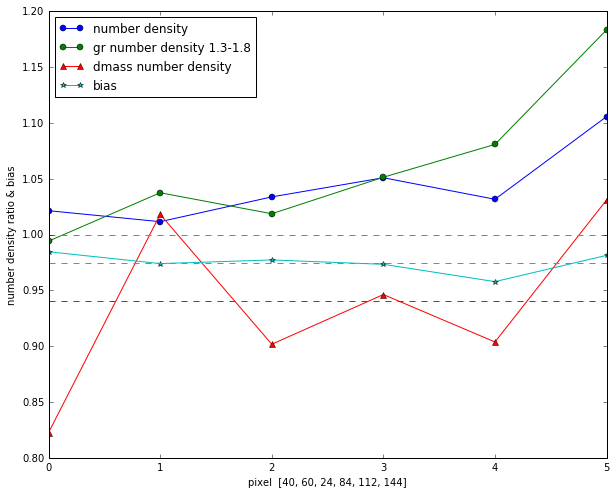

In [323]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(range(len(pix2)), nd_ratio2, '-o', label = 'number density' )
ax.plot(range(len(pix2)), nd_gr2, '-o', label = 'gr number density 1.3-1.8' )
ax.plot(range(len(pix2)), nd_ratio_cmass2, '-^', label='dmass number density')
ax.axhline(y = num_dmass, linestyle='--', color=ax.lines[-1].get_color())
ax.plot(range(len(pix2)), bias_ratio2, '-*', label = 'bias')
ax.axhline(y = avg_b_dmass, linestyle='--', color=ax.lines[-1].get_color())
ax.axhline(y = 1.0, linestyle='--', color = 'grey')
ax.set_ylim(0.8, 1.20)
ax.set_xlabel('pixel  ' + str(pix2))
ax.set_ylabel('number density ratio & bias')
ax.legend(loc='best')

figsave : figure/spatialtest_buz_test2.png


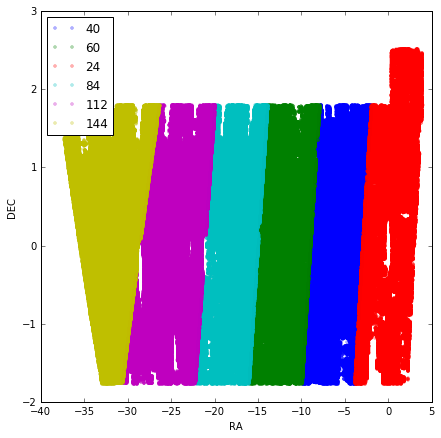

In [275]:
spatialcheck(buz_test_list2, label=pix2, suffix = 'buz_test2')

In [296]:
# testing for other regions 
import esutil

path = '/n/des/lee.5922/data/buzzard/'
buz_test_list2 = []
pix2 = [40, 60, 24, 84, 112, 144] # + [90, 91]

names = []
for p in pix:
    names.append(path+'Buzzard_v1.1_Y1A1.'+str(p)+'.fit')

buz_test = esutil.io.read(names, combine=True)
buz_test = priorCut_buz(buz_test)
buz_test = Cuts.keepGoodRegion(buz_test)
avg_buz_test = assignCMASSProb( buz_test, clf_cmass, clf_no, cmass_fraction = cmass_fraction ) 
#    buz_test_list2.append(cat)
#    cat = None

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 50 %

Process Process-29687:
Process Process-29685:
Process Process-29684:
Process Process-29679:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
    self.run()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "xd.py", line 1883, in logprob_process
    re = classname.logprob_a(data, cov)
  File "xd.py", line 171, in logprob_a
    return log_multivariate_gaussian(X, self.mu, T, parallel = parallel) + np.lo

KeyboardInterrupt: 

In [302]:
avg_buz_test.size, avg_dmass_buz.size

(4554310, 40967)

In [303]:
avg_buz_test = np.hstack(buz_test_list)
avg_dmass_buz = np.hstack(dmass_buz_list)
#dmass_buz , _ = resampleWithPth( avg_buz_test, pstart = 0, pmax = 1.0 )
test_area = np.sum([getHPArea(pix = p) for p in pix])
num_dmass = avg_dmass_buz.size/test_area
avg_b_dmass = getavgbias( avg_dmass_buz )
nd_test =  avg_buz_test.size/test_area
print num_dmass/num_density, avg_b_dmass/avg_b_cmass, nd_test/nd

avg bias= 1.29506653903  sample size= 40967
0.97429553093 0.969667480344 1.05117928478


In [295]:
dmass_buz , _ = resampleWithPth( avg_buz_test2, pstart = 0, pmax = 1.0 )
test_area = np.sum([getHPArea(pix = p) for p in pix2])
num_dmass = dmass_buz.size/test_area
avg_b_dmass = getavgbias( dmass_buz )
nd_test =  avg_buz_test2.size/test_area
print num_dmass/num_density, avg_b_dmass/avg_b_cmass, nd_test/nd

104.367476178
avg bias= 1.30672849261  sample size= 10872
0.939121095566 0.978399245705 1.04379135001


In [294]:
train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
nd =  merged_buz.size/train_area
print nd

11429.4415069


#### Compare Underlying distribution in train and another area

In [181]:
buz_test = fitsio.read(path+'Buzzard_v1.1_Y1A1.60.fit') # test sample
buz_test = priorCut_buz(buz_test)
#buz_test = fitsio.read(path+'Buzzard_v1.1_Y1A1.7.fit')

figsave : figure/spatialtest_.png


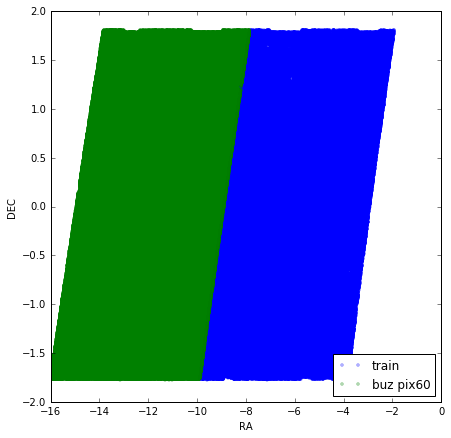

In [110]:
# add map area
spatialcheck([des_train,buz_test], label=['train', 'buz pix60'])

figsave : figure/spatialtest_test.png


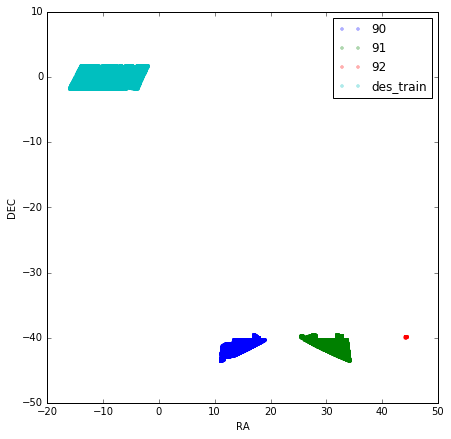

In [249]:
spatialcheck(buz_test_list2 + [des_train], label=pix2 + ['des_train'], suffix = 'test')

In [183]:
# train
pickleFileName = 'pickle/buz_XD_all.pkl'
pickleFileName = 'pickle/buz_XD_no_tor.pkl'
rows = np.random.choice(des_train.size, size=int(des_train.size /10.))                    
clf1 = XD_fitting2( des_train[rows], pickleFileName = pickleFileName, \
                  init_params= 'pickle/buz_XD_no_tor.pkl', suffix = '_all', n_cl = 25 )
# buzzard pix60
pickleFileName = 'pickle/buz_XD_all2.pkl'
rows = np.random.choice(buz_test.size, size=int(buz_test.size /10.))                    
clf2 = XD_fitting2( buz_test[rows], pickleFileName = pickleFileName, \
                  init_params= 'pickle/buz_XD_all.pkl', suffix = '_all', n_cl = 25 )

@pickle_results: using precomputed results from 'pickle/buz_XD_all.pkl'
@pickle_results: using precomputed results from 'pickle/buz_XD_all2.pkl'


In [184]:
# make clean sample (w/o noise)
clean_all1 = clf1.sample(des_train.size)
clean_all2 = clf2.sample(des_train.size)

writing output plot to: figure/buz_underlying_diagnostic_histograms_1d.png


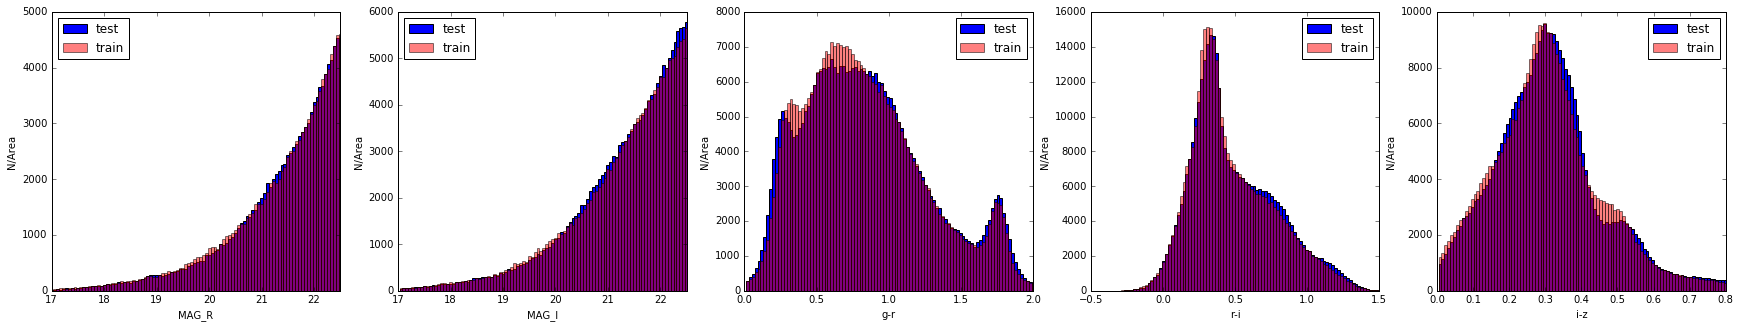

In [185]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [0,2], [-.5,1.5], [0.0,.8]]
doVisualization_1d_NperA( clean_all1, clean_all2, area=[1,1], labels = labels, ranges = ranges,\
                         name =['train','test' ], nbins=100, prefix='buz_underlying_')

----

##### Calling Gold mask and calculating map area

In [1]:
# calling map 
GoldMask = Cuts.limitingDepth(callingEliGoldMask())
GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 50, dec=-52, dec2 = -50)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

NameError: name 'Cuts' is not defined

##### DES + GOLD catalogs 

In [2]:
# calling gold + des catalog
merged_des_st82 = fitsio.read('result_cat/merged_des_st82.fits') # in stripe82
merged_des_patch = fitsio.read('result_cat/merged_des_patch.fits') # spt 0<ra<50, -52<dec<-50

In [4]:
# prior Cut
merged_des_st82_s, _ = priorCut( merged_des_st82 )
merged_des_s, _ = priorCut( merged_des_patch )

#check number density after prior Cut
n_spt = merged_des_s.size * 1./SPTMaparea
n_st82 = merged_des_st82_s.size * 1./ST82Maparea
print 'number density (patch, st82) ', n_spt, n_st82

prior cut  1565228
prior cut  690475


##### CMASS in des catalog 

In [7]:
# calling cmass
cmass = io.getSGCCMASSphotoObjcat()
cmass = Cuts.keepGoodRegion(cmass)
cmass = Cuts.SpatialCuts(cmass, ra=320, ra2=360, dec=-2, dec2=2)
m1, m2, _ = esutil.htm.HTM(10).match(cmass['RA'], cmass['DEC'], merged_des_st82['RA'], merged_des_st82['DEC'], 1./3600, maxmatch=1)
cmass_mask = np.zeros(merged_des_st82.size, dtype=bool)
cmass_mask[m2] = 1
clean_cmass_data_des, nocmass = merged_des_st82[cmass_mask], merged_des_st82[~cmass_mask]

Applying Healpix BOSS SGC footprint mask
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
Spatial Cut  12349


##### Assigning CMASS membership probability with XD algorithm 

In [8]:
# get cmass membership prob

# divide sample into train and test
(trainInd, testInd), _ = split_samples(merged_des_st82_s, merged_des_st82_s, [0.1,0.9], random_state=0)
des_train = merged_des_st82_s[trainInd]
#des_test = merged_des_st82_s[testInd]

prefix = 'gold_st82_20_'
result_gold_st82 = XDGMM_model(clean_cmass_data_des, clean_cmass_data_des, train=des_train, test=merged_des_st82_s, prefix = prefix )
result_gold_patch = XDGMM_model(clean_cmass_data_des, clean_cmass_data_des, train=des_train, test=merged_des_patch, prefix = prefix, spt=True )

prior cut  156522
prior cut  1565228
num of cmass in train 947  fraction  0.006050267694
train/test 156522 1565228
@pickle_results: using precomputed results from 'pickle/gold_st82_20_XD_all_tor.pkl'
@pickle_results: using precomputed results from 'pickle/gold_st82_20_XD_no_tor.pkl'
@pickle_results: using precomputed results from 'pickle/gold_st82_20_XD_cmass.pkl'
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
add noise to samples...


NameError: name 'merged_des' is not defined